In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import math
import seaborn as sns


from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.model_selection import train_test_split



In [2]:
data_file = 'owid-co2-data.csv' #import data file
time_period = 60 # years
end_date = 2020 

In [3]:
# Read and display csv file
df = pd.read_csv(data_file)

In [4]:
df.index = pd.to_datetime(df['year'], format="%Y") #Convert year to datetime format, make into index
df = df[['country','co2','population','gdp']] #Filter out relevant columns

In [5]:
df2 = df.ffill(axis = 0) #Forward fill null or blank values

In [6]:
df3 = pd.pivot_table(df2,index=['year'],columns=["country"], values=["co2","population","gdp"]) #Pivtoing table

In [7]:
#Filter out all dates before 1960
df3 = df3.loc[(df3.index >= (pd.to_datetime(end_date, format='%Y') - relativedelta(years=time_period)))]
#Drop any countries that do not have 60 years of data in a row
df3 = df3.dropna(axis = 1)


In [8]:
top_country_emissions = df3['co2'].sum().nlargest(n=30) #Get top 30 emitters
top_country_emissions

country
World                            1399096.294
High-income countries             709485.642
Asia                              513924.775
Upper-middle-income countries     476690.980
Europe                            387346.187
North America                     353297.360
United States                     300463.019
European Union (28)               243060.826
China                             231261.562
Asia (excl. China & India)        230970.870
European Union (27)               209051.156
Europe (excl. EU-27)              178295.034
Lower-middle-income countries     155248.751
Europe (excl. EU-28)              144285.361
Russia                            102955.254
Japan                              60101.650
Germany                            57194.078
North America (excl. USA)          52834.344
India                              51692.351
Africa                             44740.824
International transport            40446.743
South America                      40162.770
Un

In [9]:
bottom_country_emissions = df3['co2'].sum().nsmallest(n=30) #Get bottom 30 emitters
bottom_country_emissions

country
Leeward Islands                      2.013
St. Kitts-Nevis-Anguilla             2.627
Sao Tome and Principe                3.313
Saint Pierre and Miquelon            3.368
Tonga                                4.316
Dominica                             4.766
Comoros                              5.290
Samoa                                6.691
Saint Vincent and the Grenadines     6.891
Grenada                              8.150
Guinea-Bissau                        9.999
Solomon Islands                     10.371
Central African Republic            10.448
Palau                               10.500
Puerto Rico                         12.749
Burundi                             12.927
Cape Verde                          12.932
Gambia                              13.801
Saint Lucia                         14.270
Eritrea                             18.438
Djibouti                            18.588
Belize                              18.767
Antigua and Barbuda                 21.448
Bon

In [10]:
main_df = df3.loc[:,(slice(None), ["United States","China", "Russia", "Japan","Germany"])] #Get only top 5 countries
main_df.columns = [' '.join(col) for col in main_df.columns.values] 
main_df

,co2 United States,gdp United States,population United States,co2 China,gdp China,population China,co2 Russia,gdp Russia,population Russia,co2 Japan,gdp Japan,population Japan,co2 Germany,gdp Germany,population Germany
year,,,,,,,,,,,,,,,
1960-01-01,2897.138,3.260000e+12,186720570.0,798.800,7.050000e+11,6.604081e+08,882.927,6.650000e+11,119871700.0,232.500,5.980000e+11,93673612.0,813.950,8.900000e+11,73414229.0
1961-01-01,2886.696,3.340000e+12,189569850.0,570.630,5.770000e+11,6.709527e+08,910.542,7.130000e+11,121403897.0,282.787,6.700000e+11,94560714.0,834.840,9.270000e+11,73928077.0
1962-01-01,2993.718,3.540000e+12,192313747.0,459.618,6.170000e+11,6.821027e+08,955.667,7.650000e+11,122858215.0,292.864,7.300000e+11,95458517.0,883.169,9.660000e+11,74489450.0
1963-01-01,3126.294,3.690000e+12,194932400.0,456.779,7.060000e+11,6.943391e+08,1024.911,7.960000e+11,124210253.0,324.835,7.920000e+11,96389422.0,945.498,9.940000e+11,75080749.0
1964-01-01,3264.111,3.910000e+12,197408497.0,460.637,8.050000e+11,7.082546e+08,1090.020,8.480000e+11,125430991.0,358.891,8.840000e+11,97379402.0,968.917,1.050000e+12,75677305.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-01-01,5248.024,1.720000e+13,323015992.0,9720.444,1.730000e+13,1.414049e+09,1618.599,3.460000e+12,145275374.0,1203.718,4.730000e+12,127763267.0,800.687,3.740000e+12,82193770.0
2017-01-01,5207.751,1.760000e+13,325084758.0,9920.459,1.760000e+13,1.421022e+09,1646.457,3.520000e+12,145530091.0,1188.123,4.840000e+12,127502728.0,785.883,3.830000e+12,82658409.0
2018-01-01,5375.491,1.810000e+13,327096263.0,10289.990,1.820000e+13,1.427648e+09,1691.647,3.610000e+12,145734034.0,1143.458,4.870000e+12,127202190.0,754.112,3.890000e+12,83124413.0


In [37]:
#Splitting main_df into respective country dataframes
US_df1 = main_df.iloc[:,:3]
China_df1 = main_df.iloc[:,3:6]
Russia_df1 = main_df.iloc[:,6:9]
Japan_df1 = main_df.iloc[:,9:12]
Germany_df1 = main_df.iloc[:,12:15]

In [38]:
#Declaring of scalers, each scaler is specific to each country
USScaler = MinMaxScaler()
ChinaScaler = MinMaxScaler()
RussiaScaler = MinMaxScaler()
JapanScaler = MinMaxScaler()
GermanyScaler = MinMaxScaler()

#Normalizing values of all columns from 0 to 1
US_df = pd.DataFrame(data = USScaler.fit_transform(US_df1), columns = US_df1.columns, index = US_df1.index)
China_df = pd.DataFrame(data = ChinaScaler.fit_transform(China_df1), columns = China_df1.columns, index = China_df1.index)
Russia_df = pd.DataFrame(data = RussiaScaler.fit_transform(Russia_df1), columns = Russia_df1.columns, index = Russia_df1.index)
Japan_df = pd.DataFrame(data = JapanScaler.fit_transform(Japan_df1), columns = Japan_df1.columns, index = Japan_df1.index)
Germany_df = pd.DataFrame(data = GermanyScaler.fit_transform(Germany_df1), columns = Germany_df1.columns, index = Germany_df1.index)


# US LSTM Model

array([<AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
       <AxesSubplot:xlabel='year'>], dtype=object)

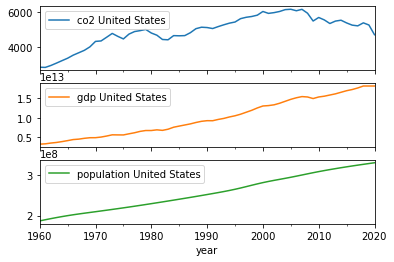

In [13]:
US_df1.plot(subplots=True)

In [14]:
#Sequencing function to properly shape the data for LSTM input
def sequence_to_X_y(df, window_size=5): #window size of 5 
    df = df.to_numpy() 
    X = [] #Create empty X and Y list
    y = []
    for i in range(len(df)-window_size): 
        row = [a for a in df[i:i+window_size]] # Place the first 5 values into the X list
        X.append(row)
        yvalue = df[i+window_size] # Place the 6th value into the Y list
        y.append(yvalue)
    return np.array(X), np.array(y)


In [15]:
# Input shape: [[a1,b1,c1],[a2,b2,c2],[a3,b3,c3],[a4,b4,c4],[a5,b5,c5]]
# Output shape: [a6,b6,c6]
USX1, USy1 = sequence_to_X_y(US_df)
print(USX1.shape, USy1.shape)
print(USX1)

(56, 5, 3) (56, 3)
[[[0.00321507 0.         0.        ]
  [0.         0.00539084 0.01974798]
  [0.0329519  0.01886792 0.03876557]
  [0.07377183 0.02897574 0.05691511]
  [0.11620546 0.04380054 0.07407661]]

 [[0.         0.00539084 0.01974798]
  [0.0329519  0.01886792 0.03876557]
  [0.07377183 0.02897574 0.05691511]
  [0.11620546 0.04380054 0.07407661]
  [0.15784286 0.0606469  0.09019214]]

 [[0.0329519  0.01886792 0.03876557]
  [0.07377183 0.02897574 0.05691511]
  [0.11620546 0.04380054 0.07407661]
  [0.15784286 0.0606469  0.09019214]
  [0.21076043 0.07884097 0.10517724]]

 [[0.07377183 0.02897574 0.05691511]
  [0.11620546 0.04380054 0.07407661]
  [0.15784286 0.0606469  0.09019214]
  [0.21076043 0.07884097 0.10517724]
  [0.25203267 0.08625337 0.11910357]]

 [[0.11620546 0.04380054 0.07407661]
  [0.15784286 0.0606469  0.09019214]
  [0.21076043 0.07884097 0.10517724]
  [0.25203267 0.08625337 0.11910357]
  [0.29373689 0.10040431 0.1322769 ]]

 [[0.15784286 0.0606469  0.09019214]
  [0.2107

In [16]:
# Define how much train and how much test (US dataset used assuming all datasets same size)
train_size = int(len(USX1) * 0.6) #60% Training
validation_size = int(len(USX1) * 0.8) #20% Validation
test_size = len(USX1) - train_size #20% Test

# Seperating dataset into train, validation and testing
USX_train1, USy_train1 = USX1[:train_size], USy1[:train_size]
USX_validation1, USy_validation1 = USX1[train_size:validation_size], USy1[train_size:validation_size]
USX_test1, USy_test1 = USX1[validation_size:], USy1[validation_size:]


In [40]:
#Building the model
modelUS = Sequential() #Specify the type of model 
modelUS.add(InputLayer((5, 3))) #Specify the shape of the inputs
modelUS.add(LSTM(64)) #Specify the number of memory inputs
modelUS.add(Dense(3, 'linear')) #Specify the output shape and activation function

modelUS.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                17408     
                                                                 
 dense_4 (Dense)             (None, 3)                 195       
                                                                 
Total params: 17,603
Trainable params: 17,603
Non-trainable params: 0
_________________________________________________________________


In [41]:
#Checkpoint system
cpUS = ModelCheckpoint('modelUS/',save_best_only=True)
#Compiling model, define learning rate and loss calculation
modelUS.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [42]:
#Fitting the training and validation data into the model, specify epochs
modelUS.fit(USX_train1, USy_train1, validation_data=(USX_validation1, USy_validation1), epochs=20, callbacks=[cpUS])

Epoch 1/20
1/2 [==============>...............] - ETA: 1s - loss: 0.1726 - root_mean_squared_error: 0.4155

INFO:tensorflow:Assets written to: modelUS\assets


INFO:tensorflow:Assets written to: modelUS\assets


2/2 [==============================] - 5s 3s/step - loss: 0.1748 - root_mean_squared_error: 0.4180 - val_loss: 0.5206 - val_root_mean_squared_error: 0.7216
Epoch 2/20
1/2 [==============>...............] - ETA: 0s - loss: 0.1473 - root_mean_squared_error: 0.3838

INFO:tensorflow:Assets written to: modelUS\assets


INFO:tensorflow:Assets written to: modelUS\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1469 - root_mean_squared_error: 0.3833 - val_loss: 0.4394 - val_root_mean_squared_error: 0.6629
Epoch 3/20
1/2 [==============>...............] - ETA: 0s - loss: 0.1233 - root_mean_squared_error: 0.3512

INFO:tensorflow:Assets written to: modelUS\assets


INFO:tensorflow:Assets written to: modelUS\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1216 - root_mean_squared_error: 0.3487 - val_loss: 0.3646 - val_root_mean_squared_error: 0.6038
Epoch 4/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0968 - root_mean_squared_error: 0.3111

INFO:tensorflow:Assets written to: modelUS\assets


INFO:tensorflow:Assets written to: modelUS\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0982 - root_mean_squared_error: 0.3134 - val_loss: 0.2941 - val_root_mean_squared_error: 0.5423
Epoch 5/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0793 - root_mean_squared_error: 0.2816

INFO:tensorflow:Assets written to: modelUS\assets


INFO:tensorflow:Assets written to: modelUS\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0773 - root_mean_squared_error: 0.2780 - val_loss: 0.2308 - val_root_mean_squared_error: 0.4804
Epoch 6/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0594 - root_mean_squared_error: 0.2437

INFO:tensorflow:Assets written to: modelUS\assets


INFO:tensorflow:Assets written to: modelUS\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0584 - root_mean_squared_error: 0.2417 - val_loss: 0.1764 - val_root_mean_squared_error: 0.4200
Epoch 7/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0430 - root_mean_squared_error: 0.2075

INFO:tensorflow:Assets written to: modelUS\assets


INFO:tensorflow:Assets written to: modelUS\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0425 - root_mean_squared_error: 0.2061 - val_loss: 0.1289 - val_root_mean_squared_error: 0.3590
Epoch 8/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0290 - root_mean_squared_error: 0.1704

INFO:tensorflow:Assets written to: modelUS\assets


INFO:tensorflow:Assets written to: modelUS\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0290 - root_mean_squared_error: 0.1702 - val_loss: 0.0885 - val_root_mean_squared_error: 0.2976
Epoch 9/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0177 - root_mean_squared_error: 0.1331

INFO:tensorflow:Assets written to: modelUS\assets


INFO:tensorflow:Assets written to: modelUS\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0178 - root_mean_squared_error: 0.1333 - val_loss: 0.0557 - val_root_mean_squared_error: 0.2360
Epoch 10/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0100 - root_mean_squared_error: 0.0999

INFO:tensorflow:Assets written to: modelUS\assets


INFO:tensorflow:Assets written to: modelUS\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0097 - root_mean_squared_error: 0.0986 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1820
Epoch 11/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0710

INFO:tensorflow:Assets written to: modelUS\assets


INFO:tensorflow:Assets written to: modelUS\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0050 - root_mean_squared_error: 0.0706 - val_loss: 0.0220 - val_root_mean_squared_error: 0.1482
Epoch 12/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0042 - root_mean_squared_error: 0.0646

INFO:tensorflow:Assets written to: modelUS\assets


INFO:tensorflow:Assets written to: modelUS\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0041 - root_mean_squared_error: 0.0640 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1425
Epoch 13/20
2/2 [==============================] - 0s 25ms/step - loss: 0.0061 - root_mean_squared_error: 0.0779 - val_loss: 0.0250 - val_root_mean_squared_error: 0.1580
Epoch 14/20
2/2 [==============================] - 0s 22ms/step - loss: 0.0092 - root_mean_squared_error: 0.0961 - val_loss: 0.0302 - val_root_mean_squared_error: 0.1737
Epoch 15/20
2/2 [==============================] - 0s 21ms/step - loss: 0.0117 - root_mean_squared_error: 0.1079 - val_loss: 0.0319 - val_root_mean_squared_error: 0.1787
Epoch 16/20
2/2 [==============================] - 0s 21ms/step - loss: 0.0122 - root_mean_squared_error: 0.1103 - val_loss: 0.0301 - val_root_mean_squared_error: 0.1735
Epoch 17/20
2/2 [==============================] - 0s 22ms/step - loss: 0.0109 - root_mean_squared_error: 0.1044 - val_loss: 0.0269 - val_root_mean_squared_error: 0

In [43]:
#Plotting a graph to compare predicted with actual train values
def US_plot_predictions(model, X, y, start=0, end=100):
    #Use model to predict based of train data, tking only the co2 values
    predictions = model.predict(X).flatten()[::3]
    #Reshape list of values to perform inverse scaling, giving us the actual co2 value predictions
    predictions = predictions.reshape(-1,1)
    predictions = np.repeat(predictions, US_df.shape[1], axis=-1)
    predictions = USScaler.inverse_transform(predictions).flatten()[::3]
    #Get actual co2 values and put them into a list
    y = y.flatten()[::3]
    #Reshape list of values to perform inverse scaling, giving us the actual co2 values
    y = y.reshape(-1,1)
    y = np.repeat(y, US_df.shape[1], axis=-1)
    y = USScaler.inverse_transform(y)[:,0]
    #Create a dataframe with both predictions and actuals
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    #Plot both against each other
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    #Get RMSE and MAPE values
    print(f"The RMSE is {mse(y, predictions, squared=False):.2f} & the MAPE is {mape(y, predictions)*100:.2f}%")
    return  
    


2/2 [==============================] - 0s 3ms/step
The RMSE is 218.60 & the MAPE is 3.76%


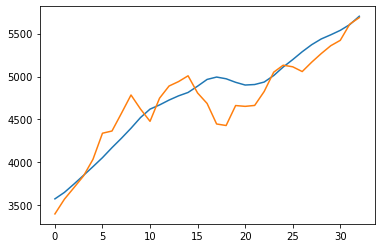

In [44]:
US_plot_predictions(modelUS, USX_train1, USy_train1)

1/1 [==============================] - 0s 15ms/step
The RMSE is 1178.92 & the MAPE is 21.87%


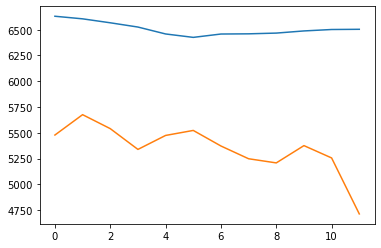

In [45]:
US_plot_predictions(modelUS, USX_test1, USy_test1)

In [46]:
n_lookback = 5  # length of input sequences (lookback period), essentially how many time steps back we look
num_prediction = 20 # Number of years predicted into future

# Get the last 5 values of the dataframe, put it into a prediction list
prediction_list = US_df[- n_lookback:].values


z = 0 #Counter variable

#Forecast the 2021 co2 value based on the last 5 years, forecast 2022 value based on the last 5 years,
#so on and so forth until the year 2040
for r in range(num_prediction):
    z += 1
    x = prediction_list[:,- n_lookback:] #Get the last 5 values of the prediction list
    x = x.reshape(-1,n_lookback,3) #Reshape for prediction
    out = modelUS.predict(x) #Forecast next value based on last 5 values
    prediction_list = np.append(prediction_list, out) #Append new value to prediction list
    prediction_list = prediction_list.reshape((1, n_lookback+z,3)) 


1/1 [==============================] - 0s 13ms/step


In [47]:
#Place forecasted values into a list
forecasted_values_US = prediction_list[:,n_lookback:] 

#Reshape list to inverse scale
forecasted_values_US = forecasted_values_US.flatten()
forecasted_values_US = forecasted_values_US.reshape(num_prediction,3)

#Inverse forecasted values to get actual co2 values
forecasted_values_US = USScaler.inverse_transform(forecasted_values_US)[:,0]

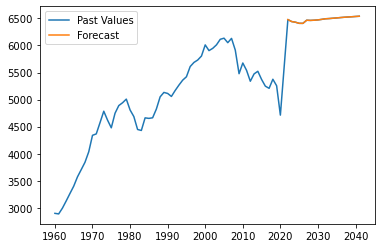

In [90]:
#Get a list of dates for forecast, in this case 2021 to 2040
predict_period_dates = pd.date_range(start= '2021-12-31', periods=num_prediction, freq='1y').tolist()

#Place forecast dates into a list
forecast_dates = []
for time_i in predict_period_dates:
     forecast_dates.append(time_i.date())

#Create a dataframe with forecast dates as well as previously forecasted values        
df_forecast_US = pd.DataFrame({'Date':np.array(forecast_dates), 'CO2':forecasted_values_US})
df_forecast_US['Date']=pd.to_datetime(df_forecast_US['Date'])
df_forecast_US = df_forecast_US.set_index('Date')

#Concatenate old values with new values into a new dataframe
combined_df = [US_df1['co2 United States'],df_forecast_US['CO2']]
result = pd.concat(combined_df)

#Plot both historical values and forecasted values

plt.plot(result, label="Past Values")
plt.plot(df_forecast_US['CO2'], label='Forecast')
plt.legend()

# China LSTM Model

array([<AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
       <AxesSubplot:xlabel='year'>], dtype=object)

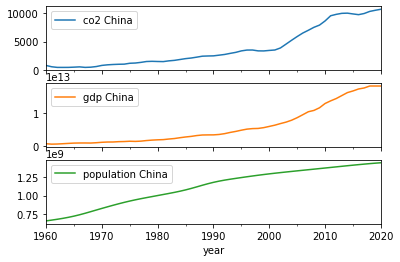

In [85]:
China_df1.plot(subplots=True)

In [92]:
ChinaX, Chinay = sequence_to_X_y(China_df)

#Since all dfs same shape and size, no need to redefine train val and test variables

train_dates, ChinaX_train, Chinay_train = China_df.index[:train_size],ChinaX[:train_size], Chinay[:train_size]
val_dates, ChinaX_validation, Chinay_validation = China_df.index[train_size:validation_size],ChinaX[train_size:validation_size], Chinay[train_size:validation_size]
test_dates, ChinaX_test, Chinay_test = China_df.index[validation_size:],ChinaX[validation_size:], Chinay[validation_size:]


In [25]:
modelChina = Sequential()
modelChina.add(InputLayer((5, 3)))
modelChina.add(LSTM(64))
modelChina.add(Dense(3, 'linear'))

modelChina.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                17408     
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 17,603
Trainable params: 17,603
Non-trainable params: 0
_________________________________________________________________


In [26]:
cpChina = ModelCheckpoint('modelChina/',save_best_only=True)
modelChina.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [27]:
modelChina.fit(ChinaX_train, Chinay_train, validation_data=(ChinaX_validation, Chinay_validation), epochs=20, callbacks=[cpChina])

Epoch 1/20
1/2 [==============>...............] - ETA: 1s - loss: 0.1309 - root_mean_squared_error: 0.3618

INFO:tensorflow:Assets written to: modelChina\assets


INFO:tensorflow:Assets written to: modelChina\assets


2/2 [==============================] - 6s 4s/step - loss: 0.1276 - root_mean_squared_error: 0.3573 - val_loss: 0.4264 - val_root_mean_squared_error: 0.6530
Epoch 2/20
1/2 [==============>...............] - ETA: 0s - loss: 0.1102 - root_mean_squared_error: 0.3320

INFO:tensorflow:Assets written to: modelChina\assets


INFO:tensorflow:Assets written to: modelChina\assets


2/2 [==============================] - 4s 4s/step - loss: 0.1107 - root_mean_squared_error: 0.3327 - val_loss: 0.3732 - val_root_mean_squared_error: 0.6109
Epoch 3/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0965 - root_mean_squared_error: 0.3106

INFO:tensorflow:Assets written to: modelChina\assets


INFO:tensorflow:Assets written to: modelChina\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0952 - root_mean_squared_error: 0.3086 - val_loss: 0.3217 - val_root_mean_squared_error: 0.5672
Epoch 4/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0820 - root_mean_squared_error: 0.2864

INFO:tensorflow:Assets written to: modelChina\assets


INFO:tensorflow:Assets written to: modelChina\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0804 - root_mean_squared_error: 0.2836 - val_loss: 0.2746 - val_root_mean_squared_error: 0.5241
Epoch 5/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0679 - root_mean_squared_error: 0.2606

INFO:tensorflow:Assets written to: modelChina\assets


INFO:tensorflow:Assets written to: modelChina\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0669 - root_mean_squared_error: 0.2586 - val_loss: 0.2314 - val_root_mean_squared_error: 0.4811
Epoch 6/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0563 - root_mean_squared_error: 0.2373

INFO:tensorflow:Assets written to: modelChina\assets


INFO:tensorflow:Assets written to: modelChina\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0547 - root_mean_squared_error: 0.2338 - val_loss: 0.1924 - val_root_mean_squared_error: 0.4387
Epoch 7/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0444 - root_mean_squared_error: 0.2107

INFO:tensorflow:Assets written to: modelChina\assets


INFO:tensorflow:Assets written to: modelChina\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0437 - root_mean_squared_error: 0.2090 - val_loss: 0.1573 - val_root_mean_squared_error: 0.3966
Epoch 8/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0342 - root_mean_squared_error: 0.1850

INFO:tensorflow:Assets written to: modelChina\assets


INFO:tensorflow:Assets written to: modelChina\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0339 - root_mean_squared_error: 0.1842 - val_loss: 0.1247 - val_root_mean_squared_error: 0.3532
Epoch 9/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0237 - root_mean_squared_error: 0.1541

INFO:tensorflow:Assets written to: modelChina\assets


INFO:tensorflow:Assets written to: modelChina\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0248 - root_mean_squared_error: 0.1576 - val_loss: 0.0939 - val_root_mean_squared_error: 0.3064
Epoch 10/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0165 - root_mean_squared_error: 0.1284

INFO:tensorflow:Assets written to: modelChina\assets


INFO:tensorflow:Assets written to: modelChina\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0169 - root_mean_squared_error: 0.1301 - val_loss: 0.0661 - val_root_mean_squared_error: 0.2570
Epoch 11/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0109 - root_mean_squared_error: 0.1042

INFO:tensorflow:Assets written to: modelChina\assets


INFO:tensorflow:Assets written to: modelChina\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0106 - root_mean_squared_error: 0.1028 - val_loss: 0.0454 - val_root_mean_squared_error: 0.2130
Epoch 12/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0062 - root_mean_squared_error: 0.0788

INFO:tensorflow:Assets written to: modelChina\assets


INFO:tensorflow:Assets written to: modelChina\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0061 - root_mean_squared_error: 0.0780 - val_loss: 0.0334 - val_root_mean_squared_error: 0.1828
Epoch 13/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0038 - root_mean_squared_error: 0.0618

INFO:tensorflow:Assets written to: modelChina\assets


INFO:tensorflow:Assets written to: modelChina\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0038 - root_mean_squared_error: 0.0616 - val_loss: 0.0290 - val_root_mean_squared_error: 0.1702
Epoch 14/20
2/2 [==============================] - 0s 25ms/step - loss: 0.0031 - root_mean_squared_error: 0.0560 - val_loss: 0.0301 - val_root_mean_squared_error: 0.1734
Epoch 15/20
2/2 [==============================] - 0s 27ms/step - loss: 0.0035 - root_mean_squared_error: 0.0588 - val_loss: 0.0343 - val_root_mean_squared_error: 0.1852
Epoch 16/20
2/2 [==============================] - 0s 28ms/step - loss: 0.0041 - root_mean_squared_error: 0.0638 - val_loss: 0.0393 - val_root_mean_squared_error: 0.1983
Epoch 17/20
2/2 [==============================] - 0s 28ms/step - loss: 0.0045 - root_mean_squared_error: 0.0671 - val_loss: 0.0425 - val_root_mean_squared_error: 0.2061
Epoch 18/20
2/2 [==============================] - 0s 30ms/step - loss: 0.0045 - root_mean_squared_error: 0.0673 - val_loss: 0.0435 - val_root_mean_squared_error: 0

In [93]:
def China_plot_predictions(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()[::3]
    predictions = predictions.reshape(-1,1)
    predictions = np.repeat(predictions, US_df.shape[1], axis=-1)
    predictions = ChinaScaler.inverse_transform(predictions).flatten()[::3]
    y = y.flatten()[::3]
    y = y.reshape(-1,1)
    y = np.repeat(y, China_df.shape[1], axis=-1)
    y = ChinaScaler.inverse_transform(y)[:,0]
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    print(f"The RMSE is {mse(y, predictions, squared=False):.2f} & the MAPE is {mape(y, predictions)*100:.2f}%")
    return  
     


2/2 [==============================] - 0s 2ms/step
The RMSE is 464.92 & the MAPE is 41.45%


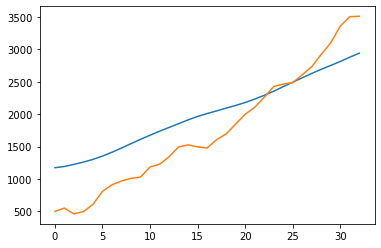

In [94]:
China_plot_predictions(modelChina, ChinaX_train, Chinay_train)

1/1 [==============================] - 0s 17ms/step
The RMSE is 5328.77 & the MAPE is 54.49%


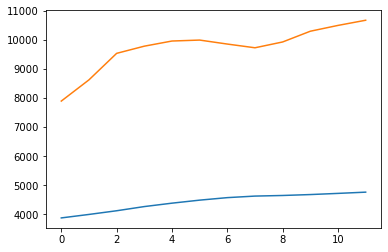

In [95]:
China_plot_predictions(modelChina, ChinaX_test, Chinay_test)

In [96]:
n_lookback = 5  # length of input sequences (lookback period), essentially how many time steps back we look
num_prediction = 20 # Number of years predicted into future

China_prediction_list = China_df[- n_lookback:].values# last available input sequence

z = 0

for r in range(num_prediction):
    z += 1
    x = China_prediction_list[:,- n_lookback:]
    x = x.reshape(-1,n_lookback,3)
    out = modelChina.predict(x)
    China_prediction_list = np.append(China_prediction_list, out)
    China_prediction_list = China_prediction_list.reshape((1, n_lookback+z,3))


1/1 [==============================] - 0s 11ms/step


In [97]:
forecasted_values_China = China_prediction_list[:,n_lookback:]

forecasted_values_China = forecasted_values_China.flatten()
forecasted_values_China = forecasted_values_China.reshape(num_prediction,3)


forecasted_values_China = ChinaScaler.inverse_transform(forecasted_values_China)[:,0]

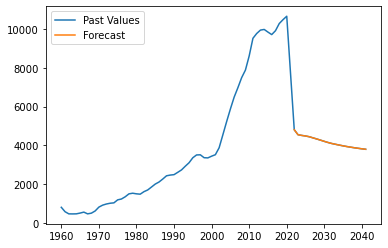

In [98]:
predict_period_dates = pd.date_range(start= '2021-12-31', periods=num_prediction, freq='1y').tolist()
# print(predict_period_dates)


forecast_dates = []
for time_i in predict_period_dates:
     forecast_dates.append(time_i.date())
    
df_forecast_China = pd.DataFrame({'Date':np.array(forecast_dates), 'CO2':forecasted_values_China})
df_forecast_China['Date']=pd.to_datetime(df_forecast_China['Date'])
df_forecast_China = df_forecast_China.set_index('Date')

combined_df = [China_df1['co2 China'],df_forecast_China['CO2']]

result = pd.concat(combined_df)


plt.plot(result, label="Past Values")
plt.plot(df_forecast_China['CO2'], label='Forecast')
plt.legend()

# Russia LSTM Model

array([<AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
       <AxesSubplot:xlabel='year'>], dtype=object)

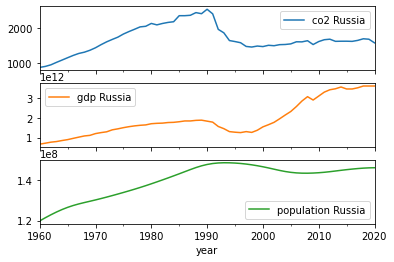

In [46]:
Russia_df1.plot(subplots=True)

In [35]:
RussiaX, Russiay = sequence_to_X_y(China_df)

#Since all dfs same shape and size, no need to redefine train val and test variables

train_dates, RussiaX_train, Russiay_train = Russia_df.index[:train_size],RussiaX[:train_size], Russiay[:train_size]
val_dates, RussiaX_validation, Russiay_validation = Russia_df.index[train_size:validation_size],RussiaX[train_size:validation_size], Russiay[train_size:validation_size]
test_dates, RussiaX_test, Russiay_test = Russia_df.index[validation_size:],RussiaX[validation_size:], Russiay[validation_size:]



In [32]:
modelRussia = Sequential()
modelRussia.add(InputLayer((5, 3)))
modelRussia.add(LSTM(64))
modelRussia.add(Dense(3, 'linear'))

modelRussia.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                17408     
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 17,603
Trainable params: 17,603
Non-trainable params: 0
_________________________________________________________________


In [33]:
cpRussia = ModelCheckpoint('modelRussia/',save_best_only=True)
modelRussia.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [36]:
modelRussia.fit(RussiaX_train, Russiay_train, validation_data=(RussiaX_validation, Russiay_validation), epochs=20, callbacks=[cpRussia])

Epoch 1/20
1/2 [==============>...............] - ETA: 1s - loss: 0.0806 - root_mean_squared_error: 0.2839

INFO:tensorflow:Assets written to: modelRussia\assets


INFO:tensorflow:Assets written to: modelRussia\assets


2/2 [==============================] - 6s 4s/step - loss: 0.0799 - root_mean_squared_error: 0.2827 - val_loss: 0.2657 - val_root_mean_squared_error: 0.5155
Epoch 2/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0671 - root_mean_squared_error: 0.2591

INFO:tensorflow:Assets written to: modelRussia\assets


INFO:tensorflow:Assets written to: modelRussia\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0654 - root_mean_squared_error: 0.2556 - val_loss: 0.2214 - val_root_mean_squared_error: 0.4705
Epoch 3/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0530 - root_mean_squared_error: 0.2303

INFO:tensorflow:Assets written to: modelRussia\assets


INFO:tensorflow:Assets written to: modelRussia\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0525 - root_mean_squared_error: 0.2290 - val_loss: 0.1810 - val_root_mean_squared_error: 0.4254
Epoch 4/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0396 - root_mean_squared_error: 0.1990

INFO:tensorflow:Assets written to: modelRussia\assets


INFO:tensorflow:Assets written to: modelRussia\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0408 - root_mean_squared_error: 0.2019 - val_loss: 0.1420 - val_root_mean_squared_error: 0.3768
Epoch 5/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0304 - root_mean_squared_error: 0.1744

INFO:tensorflow:Assets written to: modelRussia\assets


INFO:tensorflow:Assets written to: modelRussia\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0302 - root_mean_squared_error: 0.1738 - val_loss: 0.1062 - val_root_mean_squared_error: 0.3259
Epoch 6/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0197 - root_mean_squared_error: 0.1403

INFO:tensorflow:Assets written to: modelRussia\assets


INFO:tensorflow:Assets written to: modelRussia\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0205 - root_mean_squared_error: 0.1433 - val_loss: 0.0743 - val_root_mean_squared_error: 0.2727
Epoch 7/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0133 - root_mean_squared_error: 0.1152

INFO:tensorflow:Assets written to: modelRussia\assets


INFO:tensorflow:Assets written to: modelRussia\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0129 - root_mean_squared_error: 0.1136 - val_loss: 0.0492 - val_root_mean_squared_error: 0.2218
Epoch 8/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0072 - root_mean_squared_error: 0.0850

INFO:tensorflow:Assets written to: modelRussia\assets


INFO:tensorflow:Assets written to: modelRussia\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0071 - root_mean_squared_error: 0.0841 - val_loss: 0.0327 - val_root_mean_squared_error: 0.1809
Epoch 9/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0036 - root_mean_squared_error: 0.0597

INFO:tensorflow:Assets written to: modelRussia\assets


INFO:tensorflow:Assets written to: modelRussia\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0036 - root_mean_squared_error: 0.0596 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1538
Epoch 10/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0454

INFO:tensorflow:Assets written to: modelRussia\assets


INFO:tensorflow:Assets written to: modelRussia\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0020 - root_mean_squared_error: 0.0449 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1440
Epoch 11/20
2/2 [==============================] - 0s 24ms/step - loss: 0.0022 - root_mean_squared_error: 0.0470 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1518
Epoch 12/20
2/2 [==============================] - 0s 23ms/step - loss: 0.0035 - root_mean_squared_error: 0.0588 - val_loss: 0.0282 - val_root_mean_squared_error: 0.1678
Epoch 13/20
2/2 [==============================] - 0s 22ms/step - loss: 0.0046 - root_mean_squared_error: 0.0678 - val_loss: 0.0316 - val_root_mean_squared_error: 0.1777
Epoch 14/20
2/2 [==============================] - 0s 23ms/step - loss: 0.0048 - root_mean_squared_error: 0.0690 - val_loss: 0.0324 - val_root_mean_squared_error: 0.1799
Epoch 15/20
2/2 [==============================] - 0s 24ms/step - loss: 0.0041 - root_mean_squared_error: 0.0639 - val_loss: 0.0328 - val_root_mean_squared_error: 0

In [37]:
def Russia_plot_predictions(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()[::3]
    predictions = predictions.reshape(-1,1)
    predictions = np.repeat(predictions, US_df.shape[1], axis=-1)
    predictions = RussiaScaler.inverse_transform(predictions).flatten()[::3]
    y = y.flatten()[::3]
    y = y.reshape(-1,1)
    y = np.repeat(y, Russia_df.shape[1], axis=-1)
    y = RussiaScaler.inverse_transform(y)[:,0]
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    print(f"The RMSE is {mse(y, predictions, squared=False):.2f} & the MAPE is {mape(y, predictions)*100:.2f}%")
    return  
     


2/2 [==============================] - 0s 2ms/step
The RMSE is 70.62 & the MAPE is 4.37%


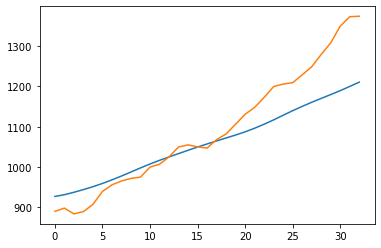

In [38]:
Russia_plot_predictions(modelRussia, RussiaX_train, Russiay_train)

1/1 [==============================] - 0s 16ms/step
The RMSE is 930.19 & the MAPE is 39.00%


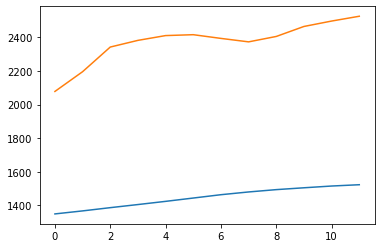

In [39]:
Russia_plot_predictions(modelRussia, RussiaX_test, Russiay_test)

In [50]:
n_lookback = 5  # length of input sequences (lookback period), essentially how many time steps back we look
num_prediction = 20 # Number of years predicted into future

Russia_prediction_list = Russia_df[- n_lookback:].values# last available input sequence

z = 0

for r in range(num_prediction):
    z += 1
    x = Russia_prediction_list[:,- n_lookback:]
    x = x.reshape(-1,n_lookback,3)
    out = modelRussia.predict(x)
    Russia_prediction_list = np.append(Russia_prediction_list, out)
    Russia_prediction_list = Russia_prediction_list.reshape((1, n_lookback+z,3))



1/1 [==============================] - 0s 13ms/step


In [51]:
forecasted_values_Russia = Russia_prediction_list[:,n_lookback:]

forecasted_values_Russia = forecasted_values_Russia.flatten()
forecasted_values_Russia = forecasted_values_Russia.reshape(num_prediction,3)

forecasted_values_Russia = RussiaScaler.inverse_transform(forecasted_values_Russia)[:,0]

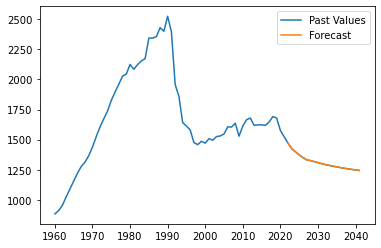

In [99]:
predict_period_dates = pd.date_range(start= '2021-12-31', periods=num_prediction, freq='1y').tolist()
# print(predict_period_dates)


forecast_dates = []
for time_i in predict_period_dates:
     forecast_dates.append(time_i.date())
    
df_forecast_Russia = pd.DataFrame({'Date':np.array(forecast_dates), 'CO2':forecasted_values_Russia})
df_forecast_Russia['Date']=pd.to_datetime(df_forecast_Russia['Date'])
df_forecast_Russia = df_forecast_Russia.set_index('Date')

combined_df = [Russia_df1['co2 Russia'],df_forecast_Russia['CO2']]

result = pd.concat(combined_df)


plt.plot(result, label="Past Values")
plt.plot(df_forecast_Russia['CO2'], label='Forecast')
plt.legend()

# Japan LSTM Model

array([<AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
       <AxesSubplot:xlabel='year'>], dtype=object)

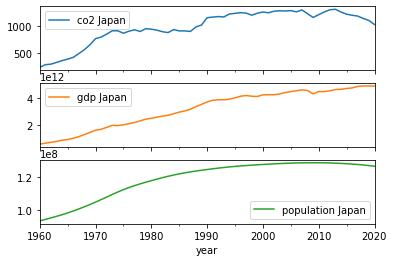

In [70]:
Japan_df1.plot(subplots=True)

In [17]:
JapanX, Japany = sequence_to_X_y(Japan_df)

#Since all dfs same shape and size, no need to redefine train val and test variables

train_dates, JapanX_train, Japany_train = Japan_df.index[:train_size],JapanX[:train_size], Japany[:train_size]
val_dates, JapanX_validation, Japany_validation = Japan_df.index[train_size:validation_size],JapanX[train_size:validation_size], Japany[train_size:validation_size]
test_dates, JapanX_test, Japany_test = Japan_df.index[validation_size:],JapanX[validation_size:], Japany[validation_size:]



In [21]:
modelJapan = Sequential()
modelJapan.add(InputLayer((5, 3)))
modelJapan.add(LSTM(64))
modelJapan.add(Dense(3, 'linear'))

modelJapan.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17408     
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 17,603
Trainable params: 17,603
Non-trainable params: 0
_________________________________________________________________


In [22]:
cpJapan = ModelCheckpoint('modelJapan/',save_best_only=True)
modelJapan.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [23]:
modelJapan.fit(JapanX_train, Japany_train, validation_data=(JapanX_validation, Japany_validation), epochs=20, callbacks=[cpJapan])

Epoch 1/20
1/2 [==============>...............] - ETA: 1s - loss: 0.3555 - root_mean_squared_error: 0.5963

INFO:tensorflow:Assets written to: modelJapan\assets


INFO:tensorflow:Assets written to: modelJapan\assets


2/2 [==============================] - 6s 4s/step - loss: 0.3631 - root_mean_squared_error: 0.6026 - val_loss: 0.6768 - val_root_mean_squared_error: 0.8227
Epoch 2/20
1/2 [==============>...............] - ETA: 0s - loss: 0.3048 - root_mean_squared_error: 0.5521

INFO:tensorflow:Assets written to: modelJapan\assets


INFO:tensorflow:Assets written to: modelJapan\assets


2/2 [==============================] - 3s 3s/step - loss: 0.3113 - root_mean_squared_error: 0.5579 - val_loss: 0.5716 - val_root_mean_squared_error: 0.7560
Epoch 3/20
1/2 [==============>...............] - ETA: 0s - loss: 0.2737 - root_mean_squared_error: 0.5232

INFO:tensorflow:Assets written to: modelJapan\assets


INFO:tensorflow:Assets written to: modelJapan\assets


2/2 [==============================] - 4s 4s/step - loss: 0.2658 - root_mean_squared_error: 0.5155 - val_loss: 0.4808 - val_root_mean_squared_error: 0.6934
Epoch 4/20
1/2 [==============>...............] - ETA: 0s - loss: 0.2248 - root_mean_squared_error: 0.4742

INFO:tensorflow:Assets written to: modelJapan\assets


INFO:tensorflow:Assets written to: modelJapan\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2248 - root_mean_squared_error: 0.4741 - val_loss: 0.4000 - val_root_mean_squared_error: 0.6324
Epoch 5/20
1/2 [==============>...............] - ETA: 0s - loss: 0.1906 - root_mean_squared_error: 0.4365

INFO:tensorflow:Assets written to: modelJapan\assets


INFO:tensorflow:Assets written to: modelJapan\assets


2/2 [==============================] - 4s 4s/step - loss: 0.1888 - root_mean_squared_error: 0.4346 - val_loss: 0.3234 - val_root_mean_squared_error: 0.5687
Epoch 6/20
1/2 [==============>...............] - ETA: 0s - loss: 0.1560 - root_mean_squared_error: 0.3950

INFO:tensorflow:Assets written to: modelJapan\assets


INFO:tensorflow:Assets written to: modelJapan\assets


2/2 [==============================] - 4s 4s/step - loss: 0.1545 - root_mean_squared_error: 0.3931 - val_loss: 0.2521 - val_root_mean_squared_error: 0.5021
Epoch 7/20
1/2 [==============>...............] - ETA: 0s - loss: 0.1232 - root_mean_squared_error: 0.3510

INFO:tensorflow:Assets written to: modelJapan\assets


INFO:tensorflow:Assets written to: modelJapan\assets


2/2 [==============================] - 4s 4s/step - loss: 0.1224 - root_mean_squared_error: 0.3499 - val_loss: 0.1858 - val_root_mean_squared_error: 0.4311
Epoch 8/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0937 - root_mean_squared_error: 0.3061

INFO:tensorflow:Assets written to: modelJapan\assets


INFO:tensorflow:Assets written to: modelJapan\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0926 - root_mean_squared_error: 0.3044 - val_loss: 0.1262 - val_root_mean_squared_error: 0.3552
Epoch 9/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0661 - root_mean_squared_error: 0.2571

INFO:tensorflow:Assets written to: modelJapan\assets


INFO:tensorflow:Assets written to: modelJapan\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0655 - root_mean_squared_error: 0.2560 - val_loss: 0.0753 - val_root_mean_squared_error: 0.2744
Epoch 10/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0438 - root_mean_squared_error: 0.2092

INFO:tensorflow:Assets written to: modelJapan\assets


INFO:tensorflow:Assets written to: modelJapan\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0425 - root_mean_squared_error: 0.2061 - val_loss: 0.0365 - val_root_mean_squared_error: 0.1909
Epoch 11/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0244 - root_mean_squared_error: 0.1563

INFO:tensorflow:Assets written to: modelJapan\assets


INFO:tensorflow:Assets written to: modelJapan\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0241 - root_mean_squared_error: 0.1552 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1084
Epoch 12/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0118 - root_mean_squared_error: 0.1088

INFO:tensorflow:Assets written to: modelJapan\assets


INFO:tensorflow:Assets written to: modelJapan\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0116 - root_mean_squared_error: 0.1079 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0355
Epoch 13/20
2/2 [==============================] - 0s 27ms/step - loss: 0.0052 - root_mean_squared_error: 0.0724 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0755
Epoch 14/20
2/2 [==============================] - 0s 25ms/step - loss: 0.0051 - root_mean_squared_error: 0.0715 - val_loss: 0.0216 - val_root_mean_squared_error: 0.1471
Epoch 15/20
2/2 [==============================] - 0s 32ms/step - loss: 0.0097 - root_mean_squared_error: 0.0984 - val_loss: 0.0395 - val_root_mean_squared_error: 0.1987
Epoch 16/20
2/2 [==============================] - 0s 27ms/step - loss: 0.0153 - root_mean_squared_error: 0.1237 - val_loss: 0.0462 - val_root_mean_squared_error: 0.2149
Epoch 17/20
2/2 [==============================] - 0s 26ms/step - loss: 0.0167 - root_mean_squared_error: 0.1294 - val_loss: 0.0395 - val_root_mean_squared_error: 0

In [53]:
def Japan_plot_predictions(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()[::3]
    predictions = predictions.reshape(-1,1)
    predictions = np.repeat(predictions, US_df.shape[1], axis=-1)
    predictions = JapanScaler.inverse_transform(predictions).flatten()[::3]
    y = y.flatten()[::3]
    y = y.reshape(-1,1)
    y = np.repeat(y, Japan_df.shape[1], axis=-1)
    y = JapanScaler.inverse_transform(y)[:,0]
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    print(f"The RMSE is {mse(y, predictions, squared=False):.2f} & the MAPE is {mape(y, predictions)*100:.2f}%")
    return  
 


2/2 [==============================] - 0s 998us/step
The RMSE is 89.83 & the MAPE is 8.49%


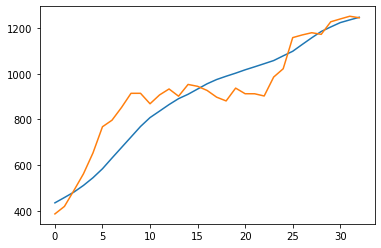

In [54]:
Japan_plot_predictions(modelJapan, JapanX_train, Japany_train)

1/1 [==============================] - 0s 15ms/step
The RMSE is 132.02 & the MAPE is 9.53%


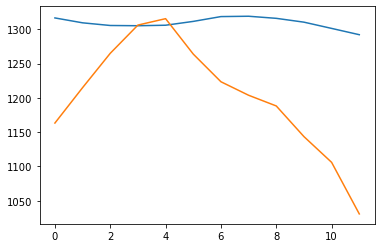

In [55]:
Japan_plot_predictions(modelJapan, JapanX_test, Japany_test)

In [56]:
n_lookback = 5  # length of input sequences (lookback period), essentially how many time steps back we look
num_prediction = 20 # Number of years predicted into future


Japan_prediction_list = Japan_df[- n_lookback:].values# last available input sequence

z = 0

for r in range(num_prediction):
    z += 1
    x = Japan_prediction_list[:,- n_lookback:]
    x = x.reshape(-1,n_lookback,3)
    out = modelJapan.predict(x)
    Japan_prediction_list = np.append(Japan_prediction_list, out)
    Japan_prediction_list = Japan_prediction_list.reshape((1, n_lookback+z,3))



1/1 [==============================] - 0s 13ms/step


In [57]:
forecasted_values_Japan = Japan_prediction_list[:,n_lookback:]

forecasted_values_Japan = forecasted_values_Japan.flatten()
forecasted_values_Japan = forecasted_values_Japan.reshape(num_prediction,3)

forecasted_values_Japan = JapanScaler.inverse_transform(forecasted_values_Japan)[:,0]

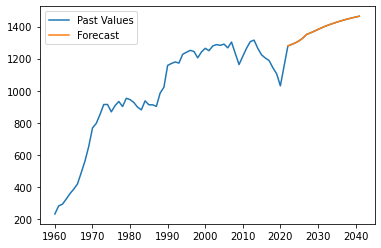

In [100]:
predict_period_dates = pd.date_range(start= '2021-12-31', periods=num_prediction, freq='1y').tolist()
# print(predict_period_dates)


forecast_dates = []
for time_i in predict_period_dates:
     forecast_dates.append(time_i.date())
    
df_forecast_Japan = pd.DataFrame({'Date':np.array(forecast_dates), 'CO2':forecasted_values_Japan})
df_forecast_Japan['Date']=pd.to_datetime(df_forecast_Japan['Date'])
df_forecast_Japan = df_forecast_Japan.set_index('Date')

combined_df = [Japan_df1['co2 Japan'],df_forecast_Japan['CO2']]

result = pd.concat(combined_df)


plt.plot(result, label="Past Values")
plt.plot(df_forecast_Japan['CO2'], label='Forecast')
plt.legend()

# Germany LSTM Model

array([<AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
       <AxesSubplot:xlabel='year'>], dtype=object)

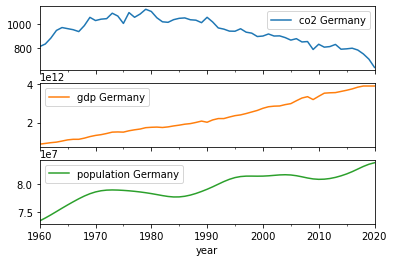

In [88]:
Germany_df1.plot(subplots=True)

In [62]:
GermanyX, Germanyy = sequence_to_X_y(Germany_df)

#Since all dfs same shape and size, no need to redefine train val and test variables

train_dates, GermanyX_train, Germanyy_train = Germany_df.index[:train_size],GermanyX[:train_size], Germanyy[:train_size]
val_dates, GermanyX_validation, Germanyy_validation = Germany_df.index[train_size:validation_size],GermanyX[train_size:validation_size], Germanyy[train_size:validation_size]
test_dates, GermanyX_test, Germanyy_test = Germany_df.index[validation_size:],GermanyX[validation_size:], Germanyy[validation_size:]



In [63]:
modelGermany = Sequential()
modelGermany.add(InputLayer((5, 3)))
modelGermany.add(LSTM(64))
modelGermany.add(Dense(3, 'linear'))

modelGermany.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64)                17408     
                                                                 
 dense_6 (Dense)             (None, 3)                 195       
                                                                 
Total params: 17,603
Trainable params: 17,603
Non-trainable params: 0
_________________________________________________________________


In [64]:
cpGermany = ModelCheckpoint('modelGermany/',save_best_only=True)
modelGermany.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [65]:
modelGermany.fit(GermanyX_train, Germanyy_train, validation_data=(GermanyX_validation, Germanyy_validation), epochs=20, callbacks=[cpGermany])

Epoch 1/20
1/2 [==============>...............] - ETA: 1s - loss: 0.2944 - root_mean_squared_error: 0.5426

INFO:tensorflow:Assets written to: modelGermany\assets


INFO:tensorflow:Assets written to: modelGermany\assets


2/2 [==============================] - 5s 3s/step - loss: 0.2943 - root_mean_squared_error: 0.5425 - val_loss: 0.3010 - val_root_mean_squared_error: 0.5487
Epoch 2/20
1/2 [==============>...............] - ETA: 0s - loss: 0.2456 - root_mean_squared_error: 0.4956

INFO:tensorflow:Assets written to: modelGermany\assets


INFO:tensorflow:Assets written to: modelGermany\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2448 - root_mean_squared_error: 0.4947 - val_loss: 0.2547 - val_root_mean_squared_error: 0.5047
Epoch 3/20
1/2 [==============>...............] - ETA: 0s - loss: 0.2005 - root_mean_squared_error: 0.4478

INFO:tensorflow:Assets written to: modelGermany\assets


INFO:tensorflow:Assets written to: modelGermany\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2003 - root_mean_squared_error: 0.4476 - val_loss: 0.2135 - val_root_mean_squared_error: 0.4621
Epoch 4/20
1/2 [==============>...............] - ETA: 0s - loss: 0.1603 - root_mean_squared_error: 0.4004

INFO:tensorflow:Assets written to: modelGermany\assets


INFO:tensorflow:Assets written to: modelGermany\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1604 - root_mean_squared_error: 0.4005 - val_loss: 0.1772 - val_root_mean_squared_error: 0.4209
Epoch 5/20
1/2 [==============>...............] - ETA: 0s - loss: 0.1263 - root_mean_squared_error: 0.3554

INFO:tensorflow:Assets written to: modelGermany\assets


INFO:tensorflow:Assets written to: modelGermany\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1250 - root_mean_squared_error: 0.3535 - val_loss: 0.1486 - val_root_mean_squared_error: 0.3854
Epoch 6/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0942 - root_mean_squared_error: 0.3070

INFO:tensorflow:Assets written to: modelGermany\assets


INFO:tensorflow:Assets written to: modelGermany\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0938 - root_mean_squared_error: 0.3063 - val_loss: 0.1258 - val_root_mean_squared_error: 0.3546
Epoch 7/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0688 - root_mean_squared_error: 0.2622

INFO:tensorflow:Assets written to: modelGermany\assets


INFO:tensorflow:Assets written to: modelGermany\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0675 - root_mean_squared_error: 0.2599 - val_loss: 0.1086 - val_root_mean_squared_error: 0.3296
Epoch 8/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0454 - root_mean_squared_error: 0.2132

INFO:tensorflow:Assets written to: modelGermany\assets


INFO:tensorflow:Assets written to: modelGermany\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0455 - root_mean_squared_error: 0.2133 - val_loss: 0.0978 - val_root_mean_squared_error: 0.3127
Epoch 9/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0291 - root_mean_squared_error: 0.1707

INFO:tensorflow:Assets written to: modelGermany\assets


INFO:tensorflow:Assets written to: modelGermany\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0289 - root_mean_squared_error: 0.1700 - val_loss: 0.0923 - val_root_mean_squared_error: 0.3038
Epoch 10/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0179 - root_mean_squared_error: 0.1339

INFO:tensorflow:Assets written to: modelGermany\assets


INFO:tensorflow:Assets written to: modelGermany\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0177 - root_mean_squared_error: 0.1331 - val_loss: 0.0912 - val_root_mean_squared_error: 0.3019
Epoch 11/20
2/2 [==============================] - 0s 21ms/step - loss: 0.0123 - root_mean_squared_error: 0.1111 - val_loss: 0.0956 - val_root_mean_squared_error: 0.3093
Epoch 12/20
2/2 [==============================] - 0s 20ms/step - loss: 0.0126 - root_mean_squared_error: 0.1122 - val_loss: 0.1046 - val_root_mean_squared_error: 0.3234
Epoch 13/20
2/2 [==============================] - 0s 21ms/step - loss: 0.0167 - root_mean_squared_error: 0.1293 - val_loss: 0.1063 - val_root_mean_squared_error: 0.3260
Epoch 14/20
2/2 [==============================] - 0s 22ms/step - loss: 0.0204 - root_mean_squared_error: 0.1427 - val_loss: 0.0998 - val_root_mean_squared_error: 0.3160
Epoch 15/20
2/2 [==============================] - 0s 22ms/step - loss: 0.0212 - root_mean_squared_error: 0.1456 - val_loss: 0.0919 - val_root_mean_squared_error: 0

INFO:tensorflow:Assets written to: modelGermany\assets


INFO:tensorflow:Assets written to: modelGermany\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0190 - root_mean_squared_error: 0.1377 - val_loss: 0.0808 - val_root_mean_squared_error: 0.2843
Epoch 17/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0158 - root_mean_squared_error: 0.1258

INFO:tensorflow:Assets written to: modelGermany\assets


INFO:tensorflow:Assets written to: modelGermany\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0157 - root_mean_squared_error: 0.1251 - val_loss: 0.0706 - val_root_mean_squared_error: 0.2656
Epoch 18/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0126 - root_mean_squared_error: 0.1121

INFO:tensorflow:Assets written to: modelGermany\assets


INFO:tensorflow:Assets written to: modelGermany\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0130 - root_mean_squared_error: 0.1140 - val_loss: 0.0621 - val_root_mean_squared_error: 0.2493
Epoch 19/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0119 - root_mean_squared_error: 0.1090

INFO:tensorflow:Assets written to: modelGermany\assets


INFO:tensorflow:Assets written to: modelGermany\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0115 - root_mean_squared_error: 0.1074 - val_loss: 0.0548 - val_root_mean_squared_error: 0.2341
Epoch 20/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0113 - root_mean_squared_error: 0.1062

INFO:tensorflow:Assets written to: modelGermany\assets


INFO:tensorflow:Assets written to: modelGermany\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0112 - root_mean_squared_error: 0.1056 - val_loss: 0.0512 - val_root_mean_squared_error: 0.2263


In [66]:
def Germany_plot_predictions(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()[::3]
    predictions = predictions.reshape(-1,1)
    predictions = np.repeat(predictions, US_df.shape[1], axis=-1)
    predictions = GermanyScaler.inverse_transform(predictions).flatten()[::3]
    y = y.flatten()[::3]
    y = y.reshape(-1,1)
    y = np.repeat(y, Germany_df.shape[1], axis=-1)
    y = GermanyScaler.inverse_transform(y)[:,0]
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    print(f"The RMSE is {mse(y, predictions, squared=False):.2f} & the MAPE is {mape(y, predictions)*100:.2f}%")
    return  
    


2/2 [==============================] - 0s 2ms/step
The RMSE is 59.62 & the MAPE is 5.15%


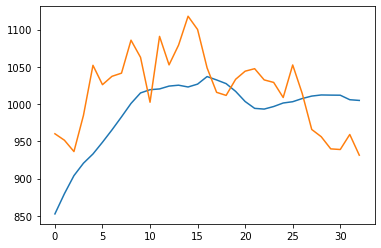

In [67]:
Germany_plot_predictions(modelGermany, GermanyX_train, Germanyy_train)

1/1 [==============================] - 0s 16ms/step
The RMSE is 176.97 & the MAPE is 22.28%


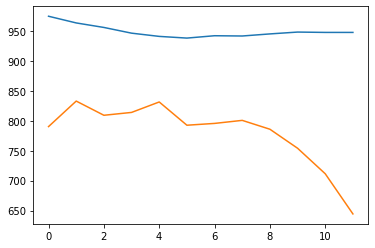

In [68]:
Germany_plot_predictions(modelGermany, GermanyX_test, Germanyy_test)

In [69]:
n_lookback = 5  # length of input sequences (lookback period), essentially how many time steps back we look
num_prediction = 20 # Number of years predicted into future


Germany_prediction_list = Germany_df[- n_lookback:].values# last available input sequence

z = 0

for r in range(num_prediction):
    z += 1
    x = Germany_prediction_list[:,- n_lookback:]
    x = x.reshape(-1,n_lookback,3)
    out = modelGermany.predict(x)
    Germany_prediction_list = np.append(Germany_prediction_list, out)
    Germany_prediction_list = Germany_prediction_list.reshape((1, n_lookback+z,3))


1/1 [==============================] - 0s 14ms/step


In [71]:
forecasted_values_Germany = Germany_prediction_list[:,n_lookback:]

forecasted_values_Germany = forecasted_values_Germany.flatten()
forecasted_values_Germany = forecasted_values_Germany.reshape(num_prediction,3)

forecasted_values_Germany = GermanyScaler.inverse_transform(forecasted_values_Germany)[:,0]

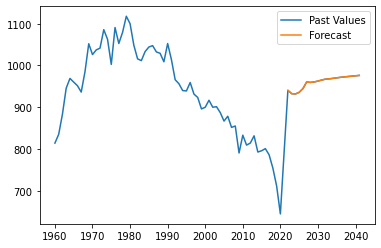

In [101]:
predict_period_dates = pd.date_range(start= '2021-12-31', periods=num_prediction, freq='1y').tolist()
# print(predict_period_dates)


forecast_dates = []
for time_i in predict_period_dates:
     forecast_dates.append(time_i.date())
    
df_forecast_Germany = pd.DataFrame({'Date':np.array(forecast_dates), 'CO2':forecasted_values_Germany})
df_forecast_Germany['Date']=pd.to_datetime(df_forecast_Germany['Date'])
df_forecast_Germany = df_forecast_Germany.set_index('Date')

combined_df = [Germany_df1['co2 Germany'],df_forecast_Germany['CO2']]

result = pd.concat(combined_df)


plt.plot(result, label="Past Values")
plt.plot(df_forecast_Germany['CO2'], label='Forecast')
plt.legend()

# US ARIMA Model

In [13]:
import pmdarima as pm #import relevant libraries

In [56]:
# Create an ARIMA model
# Specify if there is seasonality, the starting p and q order and test method to determine differencing order
ARIMAmodelUS = pm.auto_arima(US_df1['co2 United States'], seasonal_test='ocsb',
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=789.624, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=787.275, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=770.239, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=771.572, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=769.717, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=768.428, Time=0.05 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=767.205, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=767.867, Time=0.07 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=768.941, Time=0.10 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=768.556, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=767.468, Time=0.09 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=768.748, Time=0.18 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0]          
Total fi

In [25]:
# Define train and test size, 70% and 30% respectively
ARIMA_train_size = int(len(US_df1) * 0.7)
ARIMA_test_size = len(US_df1) - ARIMA_train_size

# Split dataframe into train and test sets
ARIMA_US_train = US_df1[:ARIMA_train_size]
ARIMA_US_test = US_df1[ARIMA_train_size:]


In [26]:
# Fit training data into model
ARIMAmodelUS.fit(ARIMA_US_train['co2 United States'])

# Get predictions for the test 
ARIMApredictUS = ARIMAmodelUS.predict(n_periods=len(ARIMA_US_test), return_conf_int=True)

The RMSE is 1154.56 & the MAPE is 13.55%


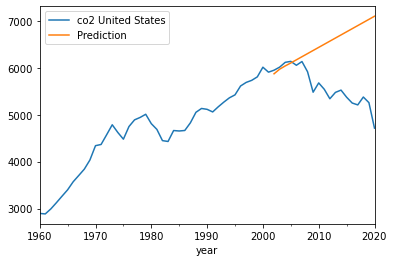

In [28]:
# Make a dataframe and plot the predicted values against the actual co2 values
US_ARIMA_predict_df = pd.DataFrame(ARIMApredictUS[0],index = ARIMA_US_test.index,columns=['Prediction'])
pd.concat([US_df1['co2 United States'],US_ARIMA_predict_df],axis=1).plot()

#Get the RMSE and MAPE comparing the predicted vs actual co2 values
print(f"The RMSE is {mse(ARIMApredictUS[0], US_df1.loc['2002-01-01':,['co2 United States']].values, squared=False):.2f} & the MAPE is {mape(ARIMApredictUS[0], US_df1.loc['2002-01-01':,['co2 United States']].values)*100:.2f}%")

In [31]:
# Generate forecasts using the model, 20 years past the last test date (2021 - 2040)
US_ARIMA_forecast= ARIMAmodelUS.predict(n_periods=len(ARIMA_US_test)+20, return_conf_int=True)
# Create a date range for 1993 - 2040
US_ARIMA_forecast_range=pd.date_range(start='1993-01-01', periods=len(ARIMA_US_test)+20,freq='Y')

#Combine forecast and date range to make a forecast df
US_ARIMA_forecast_df = pd.DataFrame(US_ARIMA_forecast[0],columns=['Forecast'])


,Prediction
2002-01-01,5870.442851
2003-01-01,5968.249499
2004-01-01,6037.481385
2005-01-01,6100.656099
2006-01-01,6167.236972
2007-01-01,6233.735634
2008-01-01,6299.966182
2009-01-01,6366.249516
2010-01-01,6432.546013
2011-01-01,6498.835879


<AxesSubplot:>

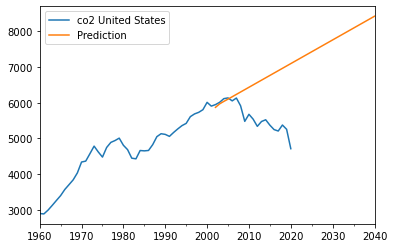

In [32]:
#Plot final forecast 
pd.concat([US_df1['co2 United States'],US_ARIMA_forecast_df],axis=1).plot()

# China ARIMA Model

In [57]:
# Create an ARIMA model
# Specify if there is seasonality, the starting p and q order and test method to determine stationarity
ARIMAmodelChina = pm.auto_arima(China_df1['co2 China'], seasonal_test='ocsb',
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=760.535, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=762.273, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=762.066, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=759.640, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=761.079, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=759.320, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=758.986, Time=0.03 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=760.942, Time=0.05 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=760.492, Time=0.11 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=760.768, Time=0.06 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0]          
Total fit time: 0.492 seconds


In [34]:
# Split dataframe into train and test sets
ARIMA_China_train = China_df1[:ARIMA_train_size]
ARIMA_China_test = China_df1[ARIMA_train_size:]


In [35]:
# Fit training data into model
ARIMAmodelChina.fit(ARIMA_China_train['co2 China'])

# Get predictions for the test 
ARIMApredictChina = ARIMAmodelChina.predict(n_periods=len(ARIMA_China_test), return_conf_int=True)

The RMSE is 4512.62 & the MAPE is 97.22%


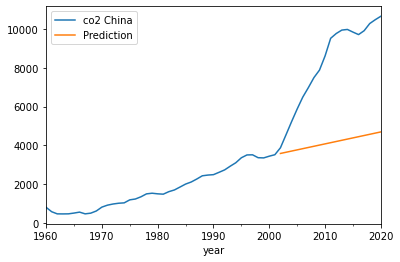

In [40]:
# Make a dataframe and plot the predicted values against the actual co2 values
China_ARIMA_predict_df = pd.DataFrame(ARIMApredictChina[0],index = ARIMA_China_test.index,columns=['Prediction'])
pd.concat([China_df1['co2 China'],China_ARIMA_predict_df],axis=1).plot()

#Get the RMSE and MAPE comparing the predicted vs actual co2 values
print(f"The RMSE is {mse(ARIMApredictChina[0], China_df1.loc['2002-01-01':,['co2 China']].values, squared=False):.2f} & the MAPE is {mape(ARIMApredictChina[0], China_df1.loc['2002-01-01':,['co2 China']].values)*100:.2f}%")

In [41]:
# Generate forecasts using the model, 20 years past the last test date (2021 - 2040)
China_ARIMA_forecast= ARIMAmodelChina.predict(n_periods=len(ARIMA_China_test)+20, return_conf_int=True)
# Create a date range for 1993 - 2040
China_ARIMA_forecast_range=pd.date_range(start='1993-01-01', periods=len(ARIMA_China_test)+20,freq='Y')

#Combine forecast and date range to make a forecast df
China_ARIMA_forecast_df = pd.DataFrame(China_ARIMA_forecast[0],columns=['Forecast'])


<AxesSubplot:>

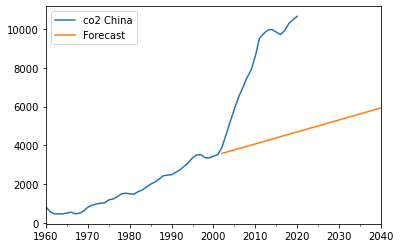

In [43]:
#Plot final forecast 
pd.concat([China_df1['co2 China'],China_ARIMA_forecast_df],axis=1).plot()

# Russia ARIMA Model

In [58]:
# Create an ARIMA model
# Specify if there is seasonality, the starting p and q order and test method to determine stationarity
ARIMAmodelRussia = pm.auto_arima(Russia_df1['co2 Russia'], seasonal_test='ocsb',
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=709.963, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=698.457, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=692.362, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=694.066, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=694.179, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=694.213, Time=0.06 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.259 seconds


In [45]:
# Split dataframe into train and test sets
ARIMA_Russia_train = Russia_df1[:ARIMA_train_size]
ARIMA_Russia_test = Russia_df1[ARIMA_train_size:]


In [47]:
# Fit training data into model
ARIMAmodelRussia.fit(ARIMA_Russia_train['co2 Russia'])

# Get predictions for the test 
ARIMApredictRussia = ARIMAmodelRussia.predict(n_periods=len(ARIMA_Russia_test), return_conf_int=True)

The RMSE is 126.17 & the MAPE is 7.48%


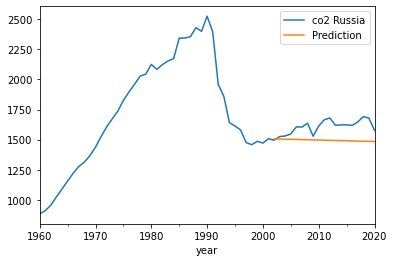

In [48]:
# Make a dataframe and plot the predicted values against the actual co2 values
Russia_ARIMA_predict_df = pd.DataFrame(ARIMApredictRussia[0],index = ARIMA_Russia_test.index,columns=['Prediction'])
pd.concat([Russia_df1['co2 Russia'],Russia_ARIMA_predict_df],axis=1).plot()

#Get the RMSE and MAPE comparing the predicted vs actual co2 values
print(f"The RMSE is {mse(ARIMApredictRussia[0], Russia_df1.loc['2002-01-01':,['co2 Russia']].values, squared=False):.2f} & the MAPE is {mape(ARIMApredictRussia[0], Russia_df1.loc['2002-01-01':,['co2 Russia']].values)*100:.2f}%")

In [49]:
# Generate forecasts using the model, 20 years past the last test date (2021 - 2040)
Russia_ARIMA_forecast= ARIMAmodelRussia.predict(n_periods=len(ARIMA_Russia_test)+20, return_conf_int=True)
# Create a date range for 1993 - 2040
Russia_ARIMA_forecast_range=pd.date_range(start='1993-01-01', periods=len(ARIMA_Russia_test)+20,freq='Y')

#Combine forecast and date range to make a forecast df
Russia_ARIMA_forecast_df = pd.DataFrame(Russia_ARIMA_forecast[0],columns=['Forecast'])


<AxesSubplot:>

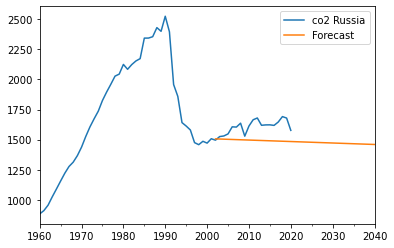

In [50]:
#Plot final forecast 
pd.concat([Russia_df1['co2 Russia'],Russia_ARIMA_forecast_df],axis=1).plot()

# Japan ARIMA Model

In [59]:
# Create an ARIMA model
# Specify if there is seasonality, the starting p and q order and test method to determine stationarity
ARIMAmodelJapan = pm.auto_arima(Japan_df1['co2 Japan'], seasonal_test='ocsb',
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=629.817, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=620.423, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=611.519, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=612.318, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=612.537, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=614.137, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.256 seconds


In [60]:
# Split dataframe into train and test sets
ARIMA_Japan_train = Japan_df1[:ARIMA_train_size]
ARIMA_Japan_test = Japan_df1[ARIMA_train_size:]


In [61]:
# Fit training data into model
ARIMAmodelJapan.fit(ARIMA_Japan_train['co2 Japan'])

# Get predictions for the test 
ARIMApredictJapan = ARIMAmodelJapan.predict(n_periods=len(ARIMA_Japan_test), return_conf_int=True)

The RMSE is 124.67 & the MAPE is 6.58%


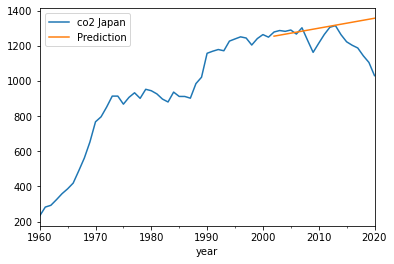

In [62]:
# Make a dataframe and plot the predicted values against the actual co2 values
Japan_ARIMA_predict_df = pd.DataFrame(ARIMApredictJapan[0],index = ARIMA_Japan_test.index,columns=['Prediction'])
pd.concat([Japan_df1['co2 Japan'],Japan_ARIMA_predict_df],axis=1).plot()

#Get the RMSE and MAPE comparing the predicted vs actual co2 values
print(f"The RMSE is {mse(ARIMApredictJapan[0], Japan_df1.loc['2002-01-01':,['co2 Japan']].values, squared=False):.2f} & the MAPE is {mape(ARIMApredictJapan[0], Japan_df1.loc['2002-01-01':,['co2 Japan']].values)*100:.2f}%")

In [63]:
# Generate forecasts using the model, 20 years past the last test date (2021 - 2040)
Japan_ARIMA_forecast= ARIMAmodelJapan.predict(n_periods=len(ARIMA_Japan_test)+20, return_conf_int=True)
# Create a date range for 1993 - 2040
Japan_ARIMA_forecast_range=pd.date_range(start='1993-01-01', periods=len(ARIMA_Japan_test)+20,freq='Y')

#Combine forecast and date range to make a forecast df
Japan_ARIMA_forecast_df = pd.DataFrame(Japan_ARIMA_forecast[0],columns=['Forecast'])


<AxesSubplot:>

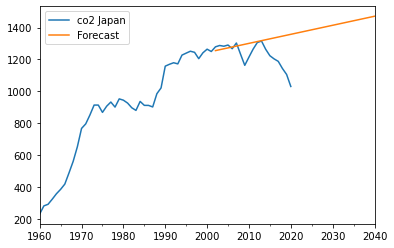

In [64]:
#Plot final forecast 
pd.concat([Japan_df1['co2 Japan'],Japan_ARIMA_forecast_df],axis=1).plot()

# Germany ARIMA Model

In [66]:
# Create an ARIMA model
# Specify if there is seasonality, the starting p and q order and test method to determine stationarity
ARIMAmodelGermany = pm.auto_arima(Germany_df1['co2 Germany'], seasonal_test='ocsb',
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=592.447, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=594.423, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=594.424, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=590.896, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=596.297, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.670 seconds


In [67]:
# Split dataframe into train and test sets
ARIMA_Germany_train = Germany_df1[:ARIMA_train_size]
ARIMA_Germany_test = Germany_df1[ARIMA_train_size:]


In [68]:
# Fit training data into model
ARIMAmodelGermany.fit(ARIMA_Germany_train['co2 Germany'])

# Get predictions for the test 
ARIMApredictGermany = ARIMAmodelGermany.predict(n_periods=len(ARIMA_Germany_test), return_conf_int=True)

The RMSE is 118.99 & the MAPE is 10.99%


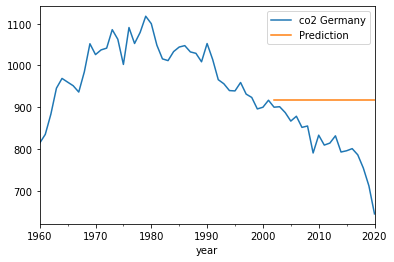

In [69]:
# Make a dataframe and plot the predicted values against the actual co2 values
Germany_ARIMA_predict_df = pd.DataFrame(ARIMApredictGermany[0],index = ARIMA_Germany_test.index,columns=['Prediction'])
pd.concat([Germany_df1['co2 Germany'],Germany_ARIMA_predict_df],axis=1).plot()

#Get the RMSE and MAPE comparing the predicted vs actual co2 values
print(f"The RMSE is {mse(ARIMApredictGermany[0], Germany_df1.loc['2002-01-01':,['co2 Germany']].values, squared=False):.2f} & the MAPE is {mape(ARIMApredictGermany[0], Germany_df1.loc['2002-01-01':,['co2 Germany']].values)*100:.2f}%")

In [70]:
# Generate forecasts using the model, 20 years past the last test date (2021 - 2040)
Germany_ARIMA_forecast= ARIMAmodelGermany.predict(n_periods=len(ARIMA_Germany_test)+20, return_conf_int=True)
# Create a date range for 1993 - 2040
Germany_ARIMA_forecast_range=pd.date_range(start='1993-01-01', periods=len(ARIMA_Germany_test)+20,freq='Y')

#Combine forecast and date range to make a forecast df
Germany_ARIMA_forecast_df = pd.DataFrame(Germany_ARIMA_forecast[0],columns=['Forecast'])


<AxesSubplot:>

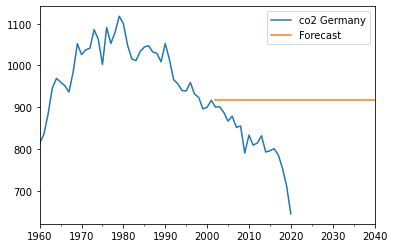

In [72]:
#Plot final forecast 
pd.concat([Germany_df1['co2 Germany'],Germany_ARIMA_forecast_df],axis=1).plot()